# Preprocessing of passengersWW.csv

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load data
passengersWW = pd.read_csv('../data/raw/passengersWW.csv', dtype='str')
passengersWW

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,flight_number_1,departure_IATA_1,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2
0,Gabriela Schmidlin,f,24/06/1984,HND,yes,no,Brief Case (4L),744.43,744.43,0.0,6U 2572,HND,ADD,NaN,NaN,NaN
1,Kaixin Banacloche,f,31/05/1992,KUL,yes,no,Duffel Bag 12KG,732.68,732.68,0.0,AF 1390,KUL,AMS,NaN,NaN,NaN
2,Manuela Thalberg,f,11/05/1964,HND,yes,no,Duffel Bag 7lbs,523.7,523.7,0.0,SQ 1981,BNE,HND,NaN,NaN,NaN
3,Klaudia Osterhagen,f,17/09/1994,SFO,no,yes,Duffel Bag 16L,876.85,876.85,0.0,IBE 4556,DEL,SFO,NaN,NaN,NaN
4,Cris Caci,f,20/06/1990,JFK,yes,no,Cosmetic Case (3lbs),1077.7,1634.2,556.5,EK 0016,CPT,JFK,QR 8307,JFK,HAV
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73135,Manuela Holtzmann,f,13/02/1978,EZE,no,no,Messenger Bag (3kg),683.03,683.03,0.0,EIN 4187,MSP,EZE,NaN,NaN,NaN
73136,Uwe Gruenewald,m,23/04/1989,DFW,no,no,Trolley 27l,326.5,326.5,0.0,AXM 8416,DFW,UIO,NaN,NaN,NaN
73137,Dona Neish,f,06/10/1999,EZE,no,no,Backpack 11lbs,528.75,528.75,0.0,VA 5254,ACA,EZE,NaN,NaN,NaN
73138,Dennis Kuster,m,11/03/1972,HKG,no,no,Brief Case 2kg,598.48,598.48,0.0,EIN 4910,BJV,HKG,NaN,NaN,NaN


## Preprocessing steps

In [3]:
### check for row duplicates
print(len(passengersWW[passengersWW.duplicated()]))
passengersWW.drop_duplicates(inplace=True)

### transform birth_date to unified date format
passengersWW['birth_date'] =  pd.to_datetime(passengersWW['birth_date'])

### cast dtypes
passengersWW['total_flighttime'] = passengersWW['total_flighttime'].astype('float32')
passengersWW['total_traveltime'] = passengersWW['total_traveltime'].astype('float32')
passengersWW['layover_time'] = passengersWW['layover_time'].astype('float32')

### upper/lower strings
passengersWW['luggage'] = passengersWW['luggage'].str.lower()
passengersWW['name'] = passengersWW['name'].str.lower()
passengersWW['shopped_at'] = passengersWW['shopped_at'].str.upper()
passengersWW['departure_IATA_1'] = passengersWW['departure_IATA_1'].str.upper()
passengersWW['destination_IATA_1'] = passengersWW['destination_IATA_1'].str.upper()
passengersWW['departure_IATA_2'] = passengersWW['departure_IATA_2'].str.upper()
passengersWW['destination_IATA_2'] = passengersWW['destination_IATA_2'].str.upper()


### make binary
passengersWW.loc[passengersWW['business_trip'] == 'no', 'business_trip'] = 0
passengersWW.loc[passengersWW['business_trip'] == 'yes', 'business_trip'] = 1

passengersWW.loc[passengersWW['traveled_with_family'] == 'no', 'traveled_with_family'] = 0
passengersWW.loc[passengersWW['traveled_with_family'] == 'yes', 'traveled_with_family'] = 1


### extract airline designator
# flight 1
passengersWW['airline_1'] = pd.Series(passengersWW['flight_number_1'].str.split(' ').str[0])

# flight 2
passengersWW['airline_2'] = pd.Series(passengersWW['flight_number_2'].str.split(' ').str[0])



### extract luggage size
# extract lbs
lbs_to_kg = 0.453592
lbs = passengersWW['luggage'].str.extract('(\d+lbs)')[0]
lbs = lbs.str.extract('(\d+)')
passengersWW['luggage_size'] = lbs.astype(float) * lbs_to_kg

# extract kg
kg = passengersWW[~passengersWW['luggage'].str.contains('lbs')]['luggage'].str.extract('(\d+kg|\d+l)')[0]
kg = kg.str.extract('(\d+)')[0].astype(float)
passengersWW['luggage_size'] = passengersWW['luggage_size'].fillna(kg)


### extract luggage type
passengersWW['luggage_type'] = pd.Series([' '.join(row[:-1]) for row in passengersWW['luggage'].str.split(' ').to_numpy()])


### flag shopping airport as start, intermediate or end
passengersWW['shopped_at_stage'] = np.NaN # default for shopping airports which are not part of flight scheme
passengersWW.loc[passengersWW['shopped_at'] == passengersWW['departure_IATA_1'], 'shopped_at_stage'] = 'start'
passengersWW.loc[(passengersWW['shopped_at'] == passengersWW['destination_IATA_2']) | 
                    ( (passengersWW['shopped_at'] == passengersWW['destination_IATA_1']) & (passengersWW['destination_IATA_2']).isna() ), 'shopped_at_stage'] = 'end'
passengersWW.loc[
    ( (passengersWW['shopped_at'] == passengersWW['destination_IATA_1']) & (~passengersWW['destination_IATA_2'].isna()) ) | 
    (passengersWW['shopped_at'] == passengersWW['departure_IATA_2']), 'shopped_at_stage'] = 'intermediate'


### drop rows with unrealistic birthdates
print(len(passengersWW[passengersWW['birth_date'] < '1920-01-01']))
passengersWW.drop(passengersWW[passengersWW['birth_date'] < '1920-01-01'].index, inplace=True)

## drop rows where shopped_at is NOT in flight scheme
not_in_flight_scheme = passengersWW[(passengersWW['shopped_at'] != passengersWW['departure_IATA_1']) &
                (passengersWW['shopped_at'] != passengersWW['destination_IATA_1']) &
                (passengersWW['shopped_at'] != passengersWW['departure_IATA_2']) &
                (passengersWW['shopped_at'] != passengersWW['destination_IATA_2'])
]
print(len(not_in_flight_scheme))
passengersWW.drop(not_in_flight_scheme.index, inplace=True)

### calculate age of passengers
passengersWW['age'] = (pd.Timestamp('2019-06-30 00:00') - passengersWW['birth_date']).astype('<m8[Y]').astype('int16')

passengersWW

5374
0
0


,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,...,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,airline_1,airline_2,luggage_size,luggage_type,shopped_at_stage,age
0,gabriela schmidlin,f,1984-06-24,HND,1,0,brief case (4l),744.429993,744.429993,0.0,...,ADD,NaN,NaN,NaN,6U,NaN,4.000000,brief case,start,35
1,kaixin banacloche,f,1992-05-31,KUL,1,0,duffel bag 12kg,732.679993,732.679993,0.0,...,AMS,NaN,NaN,NaN,AF,NaN,12.000000,duffel bag,start,27
2,manuela thalberg,f,1964-11-05,HND,1,0,duffel bag 7lbs,523.700012,523.700012,0.0,...,HND,NaN,NaN,NaN,SQ,NaN,3.175144,duffel bag,end,54
3,klaudia osterhagen,f,1994-09-17,SFO,0,1,duffel bag 16l,876.849976,876.849976,0.0,...,SFO,NaN,NaN,NaN,IBE,NaN,16.000000,duffel bag,end,24
4,cris caci,f,1990-06-20,JFK,1,0,cosmetic case (3lbs),1077.699951,1634.199951,556.5,...,JFK,QR 8307,JFK,HAV,EK,QR,1.360776,cosmetic case,intermediate,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73135,manuela holtzmann,f,1978-02-13,EZE,0,0,messenger bag (3kg),683.030029,683.030029,0.0,...,EZE,NaN,NaN,NaN,EIN,NaN,3.000000,NaN,end,41
73136,uwe gruenewald,m,1989-04-23,DFW,0,0,trolley 27l,326.500000,326.500000,0.0,...,UIO,NaN,NaN,NaN,AXM,NaN,27.000000,NaN,start,30
73137,dona neish,f,1999-06-10,EZE,0,0,backpack 11lbs,528.750000,528.750000,0.0,...,EZE,NaN,NaN,NaN,VA,NaN,4.989512,NaN,end,20
73138,dennis kuster,m,1972-11-03,HKG,0,0,brief case 2kg,598.479980,598.479980,0.0,...,HKG,NaN,NaN,NaN,EIN,NaN,2.000000,NaN,end,46


## Further data exploration

In [4]:
passengersWW.describe(include='all')

<ipython-input-4-8b7d484ee5e2>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  passengersWW.describe(include='all')


,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,...,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,airline_1,airline_2,luggage_size,luggage_type,shopped_at_stage,age
count,67766,67766,67766,67766,67766.0,67766.0,67766,67766.000000,67766.000000,67766.000000,...,67766,17020,17020,17020,67766,17020,67766.000000,63136,67766,67766.000000
unique,62970,2,18255,12,2.0,2.0,1629,NaN,NaN,NaN,...,192,4238,12,192,47,47,NaN,10,3,NaN
top,leon diederich,f,1975-05-23 00:00:00,JFK,0.0,0.0,bag 4kg,NaN,NaN,NaN,...,JFK,MS 3956,JFK,MEL,LGL,BEL,NaN,bag,start,NaN
freq,6,34045,15,6297,43311.0,54733.0,213,NaN,NaN,NaN,...,3502,26,1765,316,1695,470,NaN,11258,32709,NaN
first,NaN,NaN,1929-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2001-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,776.488342,872.734558,96.251648,...,NaN,NaN,NaN,NaN,NaN,NaN,11.607061,NaN,NaN,40.308193
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,295.281036,429.711945,195.082718,...,NaN,NaN,NaN,NaN,NaN,NaN,9.094460,NaN,NaN,12.909980
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.169998,51.169998,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,0.453592,NaN,NaN,17.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,590.849976,592.500000,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,30.000000


In [5]:
# check whether other units for luggage size are available than in EU dataset
passengersWW[passengersWW['luggage'].str.extract('(\d+kg|\d+l)')[0].isna()]
# -> same 3 units: kg, l and lbs

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,...,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,airline_1,airline_2,luggage_size,luggage_type,shopped_at_stage,age


f    34045
m    33721
Name: sex, dtype: int64


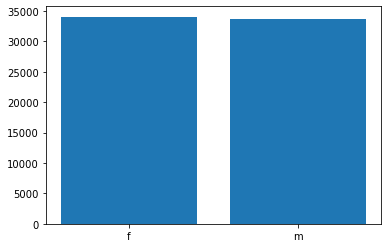

In [6]:
# proportion of sex
print(passengersWW['sex'].value_counts())
plt.bar(x=passengersWW['sex'].value_counts().index, height=passengersWW['sex'].value_counts())
plt.show()
# -> balanced

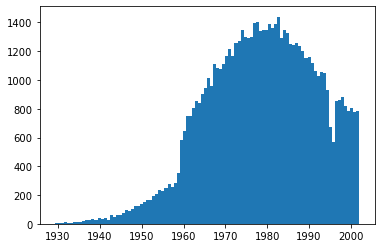

In [7]:
plt.hist(passengersWW['birth_date'], bins=100)
plt.show()

In [8]:
passengersWW[(passengersWW['business_trip'] == 'yes') & (passengersWW['traveled_with_family'] == 'yes')]
# business trip == yes & traveled with family == yes not found

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,...,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,airline_1,airline_2,luggage_size,luggage_type,shopped_at_stage,age


In [9]:
# check if total_traveltime is sum of flighttime and layover time
passengersWW[passengersWW['total_traveltime'] - (passengersWW['total_flighttime'] + passengersWW['layover_time']) > 1]
# -> no row with deviation larger than 1min

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,...,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,airline_1,airline_2,luggage_size,luggage_type,shopped_at_stage,age


In [10]:
### investigate flight schema + location of shopping/questionnaire

# is end of flight 1 = start of flight 2 always?
passengersWW[
    (passengersWW['destination_IATA_1'] != passengersWW['departure_IATA_2']) & (~passengersWW['departure_IATA_2'].isna())
]
# -> dest 1 and dep 2 never deviate from each other

passengersWW[passengersWW['destination_IATA_1'].isna()]['departure_IATA_2'].unique()
# -> if dest 1 = NaN, than dep 2 = NaN as well

passengersWW[passengersWW['destination_IATA_1'].isna() & passengersWW['destination_IATA_2'].isna()]
# -> when dest 1 and dep 2 = NaN, than is dest 2 NOT NaN

passengersWW[passengersWW['flight_number_1'].isna() == passengersWW['flight_number_2']]
# -> generally holds: flight number 1 != flight number 2

,name,sex,birth_date,shopped_at,business_trip,traveled_with_family,luggage,total_flighttime,total_traveltime,layover_time,...,destination_IATA_1,flight_number_2,departure_IATA_2,destination_IATA_2,airline_1,airline_2,luggage_size,luggage_type,shopped_at_stage,age


In [11]:
# count rows per airport
passengersWW.groupby(['shopped_at']).size()

shopped_at
DFW    5941
DXB    5963
EZE    5582
HKG    5726
HND    5914
JFK    6297
KUL    5446
MEL    4771
PEK    5674
PVG    5585
SFO    5582
SIN    5285
dtype: int64

In [12]:
# save processed data
passengersWW.to_csv('../data/processed/passengersWW.csv')